In [3]:
# This code makes Figure 1 in the main text of Rigden et al. (2025) Environmental Research: Water

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rasterio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrow
from matplotlib.ticker import MultipleLocator

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.geoaxes import GeoAxes

# === Set plot appearance ===
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 16
})

# === Load DEM (Digital Elevation Model) ===
dem_path = "example_data/DEM/hyd_af_dem_30s/hyd_af_dem_30s.tif"
with rasterio.open(dem_path) as src:
    dem_data = src.read(1).astype("float32")
    transform = src.transform
    bounds = src.bounds
    res = src.res

    # Replace invalid values (>32,000 treated as no-data)
    dem_data[dem_data > 32000] = np.nan

# === Create longitude and latitude arrays for DEM ===
nrows, ncols = dem_data.shape
lon = np.arange(bounds.left + res[0] / 2, bounds.right, res[0])
lat = np.arange(bounds.top - res[1] / 2, bounds.bottom, -res[1])
lon_grid, lat_grid = np.meshgrid(lon, lat)

# === Subset DEM to study region (Angola/Botswana area) ===
lon_mask = (lon >= 12.5) & (lon <= 25)
lat_mask = (lat >= -21) & (lat <= -10)
lon_subset = lon[lon_mask]
lat_subset = lat[lat_mask]
dem_subset = dem_data[np.ix_(lat_mask, lon_mask)]

# === Load GRACE mascon data ===
grace_subset_path = "example_data/GRACE_TWS_Angola_2002-2024.nc"  # adjust path if needed
ds = xr.open_dataset(grace_subset_path, engine="netcdf4")
lat_grace_sub = ds["lat"].values
lon_grace_sub = ds["lon"].values
lon_grid_sub, lat_grid_sub = np.meshgrid(lon_grace_sub, lat_grace_sub)
mascon_id_sub = ds["mascon_ID"].values

# === Load river basin shapefiles ===
shapefile_path = "example_data/RiverBasins/hybas_af_lev04_v1c.shp"
gdf_basins = gpd.read_file(shapefile_path)

# Define HYBAS_IDs for Cubango and Cuito basins
basin_ids_dict = {
    'cubango': [1041477980],
    'cuito': [1041479540],
    'both': [1041477980, 1041479540]
}

# Select basins to include (default = both basins)
basin_choice = 'both'
selected_ids = basin_ids_dict[basin_choice]
basins = gdf_basins[gdf_basins['HYBAS_ID'].isin(selected_ids)].to_crs("EPSG:4326")

# === Load Angolan Highland Water Tower shapefile ===
ahwt = gpd.read_file("example_data/Angolan_Highlands_Water_Tower_area/Angolan_Highlands_Water_Tower_area.shp")
ahwt = ahwt.to_crs(epsg=4326)

/var/folders/ql/gv0k21w56llc1htbtgq4wzmm0000gn/T/ipykernel_10514/298977883.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = basin.geometry.unary_union.centroid
/var/folders/ql/gv0k21w56llc1htbtgq4wzmm0000gn/T/ipykernel_10514/298977883.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = basin.geometry.unary_union.centroid
/opt/anaconda3/envs/cmip6_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/var/folders/ql/gv0k21w56llc1htbtgq4wzmm0000gn/T/ipykernel_10514/298977883.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


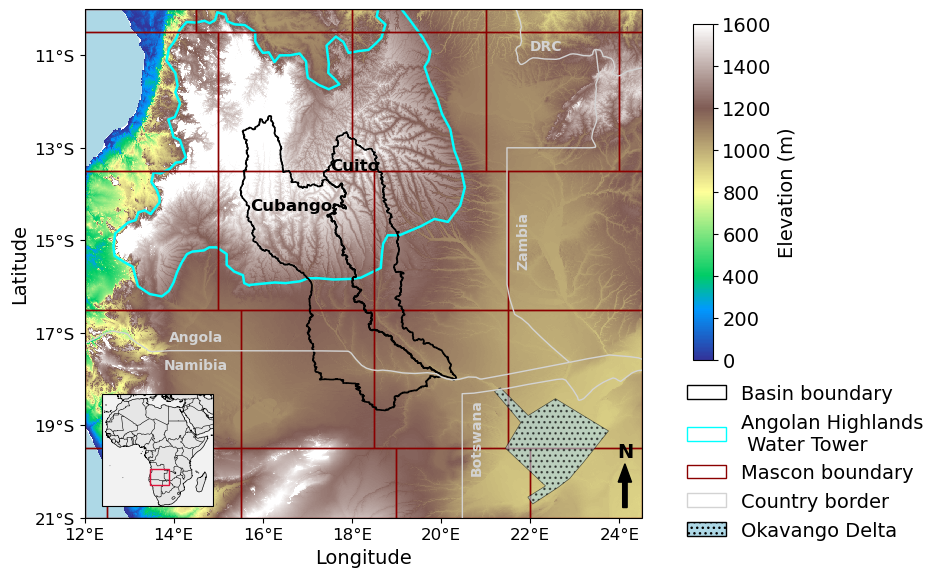

In [8]:
# Description:
# This section of the script generates a detailed map showing the Cubango and Cuito river basins, 
# GRACE mascon boundaries, elevation from a DEM, country borders, and the Okavango Delta.
# The plot includes elevation shading, labeled basins, a compass rose, a legend, and saved output as a high-resolution PDF.

# === Plot setup ===
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add light blue ocean background
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')

# Plot DEM background using pcolormesh with terrain colormap
c = ax.pcolormesh(lon_subset, lat_subset, dem_subset, shading='auto',
                  cmap='terrain', vmin=0, vmax=1600, transform=ccrs.PlateCarree())
c.set_rasterized(True)  # speeds up PDF export

# Add Angolan Highland Water Tower Contour
ahwt.plot(ax=ax, facecolor='none', edgecolor='cyan', linewidth=1.8, transform=ccrs.PlateCarree())

# Plot GRACE mascon boundaries as dark red boxes
unique_ids = np.unique(mascon_id_sub[~np.isnan(mascon_id_sub)])
for uid in unique_ids:
    mask = mascon_id_sub == uid
    if np.count_nonzero(mask) == 0:
        continue
    lon_pts = lon_grid_sub[mask]
    lat_pts = lat_grid_sub[mask]
    minx, maxx = lon_pts.min() - 0.25, lon_pts.max() + 0.25
    miny, maxy = lat_pts.min() - 0.25, lat_pts.max() + 0.25
    patch = mpatches.Polygon(
        [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)],
        edgecolor='darkred', facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
    ax.add_patch(patch)

# Plot basin boundaries
basins.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.2, transform=ccrs.PlateCarree())

# Add basin name labels at centroids
for name, ids in basin_ids_dict.items():
    if name == "both":
        continue  # skip combined entry
    basin = gdf_basins[gdf_basins['HYBAS_ID'].isin(ids)].to_crs("EPSG:4326")
    centroid = basin.geometry.unary_union.centroid
    if name == "cuito":
        ax.text(centroid.x - 0.45, centroid.y + 1.8, name.capitalize(),
                transform=ccrs.PlateCarree(),
                fontsize=12, fontweight='bold', color='black',
                ha='center', va='center')
    if name == "cubango":
        ax.text(centroid.x - 0.73, centroid.y + 1.5, name.capitalize(),
                transform=ccrs.PlateCarree(),
                fontsize=12, fontweight='bold', color='black',
                ha='center', va='center')

# Add country borders
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='lightgray', linewidth=1)

# Add country name labels
ax.text(15, -17.1, "Angola", transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center', fontweight='bold', color='lightgray')
ax.text(15, -17.7, "Namibia", transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center', fontweight='bold', color='lightgray')
ax.text(21.3, -19.25, "Botswana", transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center', fontweight='bold', color='lightgray', rotation=90)
ax.text(22.35, -15, "Zambia", transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center', fontweight='bold', color='lightgray', rotation=90)
ax.text(22.85, -10.8, "DRC", transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center', fontweight='bold', color='lightgray')

# Add compass rose (north arrow)
ax.annotate('N', xy=(0.97, 0.13), xycoords='axes fraction', ha='center', va='center', fontsize=14, fontweight='bold')
ax.add_patch(FancyArrow(0.97, 0.02, 0, 0.05, width=0.008, transform=ax.transAxes, color='k'))

# Build custom legend
legend_patches = [
    mpatches.Patch(edgecolor='black', facecolor='none', label='Basin boundary'),
    mpatches.Patch(edgecolor='cyan', facecolor='none', label='Angolan Highlands \n Water Tower'),
    mpatches.Patch(edgecolor='darkred', facecolor='none', label='Mascon boundary'),
    mpatches.Patch(edgecolor='lightgray', facecolor='none', label='Country border'),
    mpatches.Patch(facecolor='lightblue', edgecolor='black', hatch='...', label='Okavango Delta')
]
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.11), frameon=False)

# Set map extent
ax.set_extent([12.5, 25, -21, -10], crs=ccrs.PlateCarree())

# === Inset map (Africa context) ===
# Create a GeoAxes inset in the lower-left; adjust width/height/loc as you like
axins = inset_axes(
    ax, width="22%", height="22%", loc="lower left", borderpad=0.6,
    axes_class=GeoAxes, axes_kwargs=dict(map_projection=ccrs.PlateCarree())
)

# Africa-wide extent (lon_min, lon_max, lat_min, lat_max)
axins.set_extent([-20, 55, -35, 40], crs=ccrs.PlateCarree())

# Background and boundaries
axins.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='0.95')  # light gray ocean
axins.add_feature(cfeature.LAND.with_scale('50m'), facecolor='0.9')
axins.coastlines('50m', linewidth=0.5)
axins.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.4)

# Draw a rectangle for the main map extent
xmin, xmax, ymin, ymax = ax.get_extent(crs=ccrs.PlateCarree())
outline = mpatches.Rectangle(
    (xmin, ymin), xmax - xmin, ymax - ymin,
    fill=False, edgecolor='crimson', linewidth=1,
    transform=ccrs.PlateCarree(), zorder=5
)
axins.add_patch(outline)

# # Optional: mark the Okavango Delta centroid for extra clarity
# # (use your polygon coords if you want exact centroid)
# try:
#     from shapely.geometry import Polygon
#     poly = Polygon(okavango_coords)
#     cx, cy = poly.centroid.x, poly.centroid.y
#     axins.plot(cx, cy, marker='o', markersize=3, transform=ccrs.PlateCarree())
# except Exception:
#     pass

# Ticks off to keep it clean
axins.set_xticks([])
axins.set_yticks([])
for spine in axins.spines.values():
    spine.set_linewidth(0.8)

# Add latitude and longitude ticks with formatting
ax.set_xticks(np.arange(12.5, 25, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-21, -10, 2), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}°E"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{-y:.0f}°S" if y < 0 else f"{y:.0f}°N"))

# Add colorbar for DEM
cbar_ax = fig.add_axes([0.75, 0.38, 0.02, 0.56])  # [left, bottom, width, height]
cb = plt.colorbar(c, cax=cbar_ax, label="Elevation (m)")

# Add Okavango Delta polygon with stippling
# === Okavango Delta polygon ===
okavango_coords = [
    [21.995671332376105, -18.603263588516672],
    [22.290686112992944, -18.941764024773665],
    [21.945233677078022, -19.496174215276806],
    [22.84439596955849, -20.312802846252264],
    [22.446828220535053, -20.553449920435497],
    [22.55600485627724, -20.70253839312854],
    [22.92130026643349, -20.473704939798594],
    [23.13553366487099, -20.33598309288628],
    [23.39371237580849, -20.14528706879738],
    [23.444524143386616, -20.08209976623566],
    [23.67935690705849, -19.820053034004616],
    [24.256825779128803, -19.12348461449692],
    [23.482976291824116, -18.67003886902422],
    [23.367619846511616, -18.60302283521612],
    [23.271782594769547, -18.545872902487968],
    [23.06618246858193, -18.425270339271584],
    [22.455754612136616, -18.790340936600785],
    [21.83090720002724, -18.190590538447204],
    [21.700444553542866, -18.272112604111847]
]
delta_patch = mpatches.Polygon(okavango_coords, closed=True, facecolor='lightblue',
                               edgecolor='black', hatch='...', linewidth=0.5,
                               transform=ccrs.PlateCarree(), alpha=0.6)
ax.add_patch(delta_patch)

ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)

# Final layout and save as PDF
plt.tight_layout()
plt.savefig("Figures/Figure1.pdf", format="pdf", dpi=300, pad_inches=0.1)
plt.show()
